# 5. User-based Collaborative filtering

## Data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
RANDOM_STATE = 5482

We load the modified user database obtained in the data_generator.ipynb file. It contains data of only users with more than 5 listened songs. By doing this we reduce the noise added by users with only a few songs listened.

In [2]:
df_users = pd.read_csv('data/User Listening History_modified.csv')
df_users.shape

(8332242, 3)

In [3]:
df_music = pd.read_csv('data/Million Song Dataset kaggle/Music Info.csv')

In [4]:
num_distinct_users = df_users['user_id'].nunique()
num_distinct_users

464573

In [5]:
num_distinct_users = df_users['user_id'].nunique()
num_distinct_users

464573

In [6]:
df_music_info = df_music[['track_id', 'name', 'artist', 'energy']]
df_music_info.head()

,track_id,name,artist,energy
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,0.918
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,0.892
2,TROUVHL128F426C441,Come as You Are,Nirvana,0.826
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,0.664
4,TRLNZBD128F935E4D8,Creep,Radiohead,0.430


In [7]:
df_music_count = df_music_info.merge(
    df_users.groupby('track_id').size().reset_index(name='playcount'),
    on='track_id',
    how='left'
)
df_music_count = df_music_count.fillna(0)
print(df_music_count.shape)
df_music_count.head()

(50683, 5)


,track_id,name,artist,energy,playcount
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,0.918,32.0
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,0.892,283.0
2,TROUVHL128F426C441,Come as You Are,Nirvana,0.826,0.0
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,0.664,17.0
4,TRLNZBD128F935E4D8,Creep,Radiohead,0.430,0.0


In [8]:
num_distinct_users = df_users['user_id'].nunique()
num_distinct_users

464573

In [9]:
df_music_info = df_music[['track_id', 'name', 'artist', 'energy']]
df_music_info.head()

,track_id,name,artist,energy
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,0.918
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,0.892
2,TROUVHL128F426C441,Come as You Are,Nirvana,0.826
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,0.664
4,TRLNZBD128F935E4D8,Creep,Radiohead,0.430


In [10]:
df_music_count = df_music_info.merge(
    df_users.groupby('track_id').size().reset_index(name='playcount'),
    on='track_id',
    how='left'
)
df_music_count = df_music_count.fillna(0)
print(df_music_count.shape)
df_music_count.head()

(50683, 5)


,track_id,name,artist,energy,playcount
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,0.918,32.0
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,0.892,283.0
2,TROUVHL128F426C441,Come as You Are,Nirvana,0.826,0.0
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,0.664,17.0
4,TRLNZBD128F935E4D8,Creep,Radiohead,0.430,0.0


## Interaction Matrix

In [11]:
df_users_agg = df_users.groupby('user_id')['playcount'].agg(
    #total_playcount='sum',
    max_playcount='max'
).reset_index()
df_users_agg = df_users_agg.rename(columns={'playcount': 'max_playcount'})

In [12]:
df_users_rating = df_users.merge(df_users_agg, on='user_id')

We create the same 2 interaction matrix than in item-based collaborative filtering:
- Binary version
- Weighted version

In [13]:
df_users_rating['rating'] = df_users_rating['playcount'] / df_users_rating['max_playcount']

In this case, we will use the csr matrix, because in user-based collaborative filtering the data is accessed by rows.

In [14]:
from scipy.sparse import csr_matrix

In [15]:
user_codes, user_uniques = pd.factorize(df_users['user_id'])
track_codes, track_uniques = pd.factorize(df_users['track_id'])

In [16]:
interaction_matrix_csr_binary = csr_matrix((np.ones(len(df_users)), (user_codes, track_codes)),shape=(len(user_uniques), len(track_uniques)))
interaction_matrix_csr_weighted = csr_matrix((df_users_rating['rating'], (user_codes, track_codes)),shape=(len(user_uniques), len(track_uniques)))

In [17]:
interaction_matrix_csr_binary.shape

(464573, 30201)

## User based collaborative filtering Model

In [18]:
#user_similarity = cosine_similarity(interaction_matrix_csr_weighted, dense_output=False)

We can not precompute the user similarity matrix as we did with the item similarity matrix in 
item-based collaborative filtering. Due to havinf much more users than songs, the user similarity matrix would exced the amount of RAM available in the computer. Instead of precalculating it, each time a user need to get the recommendations, the similarity between him and the other users will be calculated.

In [19]:
from sklearn.neighbors import NearestNeighbors

In [20]:
class UserBasedRecommender:
    def __init__(self, interaction_matrix, track_uniques, df_music_info, num_neighbors=10):
        self.interaction_matrix = interaction_matrix
        self.knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=num_neighbors + 1, n_jobs=-1) # num_neighbors+1 because the user itself is included in the neighbors and we will ignore it
        self.knn_model.fit(interaction_matrix)
        self.track_uniques = track_uniques
        self.df_music_info = df_music_info
        self.user_index = None
        self.recommendations = None # List of tuples (track_id, energy, has been recommended)

    def make_recommendations(self, user_index, n=5):
        self.user_index = user_index

        _, neighbors_indices = self.knn_model.kneighbors(self.interaction_matrix[user_index])

        neighbors_indices = neighbors_indices[:, 1:]  # Exclude the first index which is the user itself

        neighbors_interaction_matrix = self.interaction_matrix[neighbors_indices.flatten()]

        neighbors_mean_ratings = neighbors_interaction_matrix.mean(axis=0).A1 # Converts to 1D array

        user_ratings = self.interaction_matrix[user_index]
        interacted = user_ratings.nonzero()[1]
        neighbors_mean_ratings[interacted] = -np.inf #Asign -np.inf to already listened songs by the user

        top_n_index = np.argpartition(neighbors_mean_ratings, -n)[-n:]
        top_n_index = top_n_index[np.argsort(neighbors_mean_ratings[top_n_index])[::-1]]

        # for index in top_n_index:
        #     print(f"Track ID: {self.track_uniques[index]}, Mean Rating: {neighbors_mean_ratings[index]}")
        
        track_ids = self.track_uniques[top_n_index].tolist()

        df_filtered = self.df_music_info.set_index('track_id').loc[track_ids][['energy']].reset_index()

        # print(df_filtered)

        self.recommendations = [(track_id, energy, False) for track_id, energy in df_filtered.itertuples(index=False, name=None)]

    
    def recommend_song(self, energy, energy_margin=0.05):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        
        closest_track_index = None
        distance_to_energy = float('inf')

        for i, (track_id, track_energy, has_been_recommended) in enumerate(self.recommendations):
            distance = abs(track_energy - energy)

            if not has_been_recommended and distance <= energy_margin:
                self.recommendations[i] = (track_id, track_energy, True)
                return (track_id, track_energy)
            
            if not has_been_recommended and distance < distance_to_energy:
                closest_track_index = i
                distance_to_energy = distance
        
        if closest_track_index is not None:
            track_id, track_energy, _ = self.recommendations[closest_track_index]
            self.recommendations[closest_track_index] = (track_id, track_energy, True)
            return (track_id, track_energy)

        raise ValueError("All recommendations have already been recommended")


    def get_recommendations(self):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        return self.recommendations


    def get_recommendations_ids(self):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        return [track_id for track_id, _, _ in self.recommendations]
    
    
    def get_recommendations_info(self):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        track_ids_ordered = [track_id for track_id, _, _ in self.recommendations]
        df_ordered = self.df_music_info.set_index('track_id').loc[track_ids_ordered].reset_index()
        return df_ordered

## Example

In [52]:
user_index = 0 #User for wich recommendations will be made

In [53]:
user_listened_songs = df_users[df_users['user_id'] == user_uniques[user_index]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
79,TRAAHSY128F147BB5C,Speed of Sound,Coldplay,0.8980
796,TRDLMWP128F426BF6C,Ragged Wood,Fleet Foxes,0.6850
1158,TRPUGUW128F426BF6F,He Doesn't Know Why,Fleet Foxes,0.5580
1743,TRRYCBO128F932A2C7,Love Shack,The B-52's,0.9020
2350,TRFUPBA128F934F7E1,Paper Gangsta,Lady Gaga,0.5300
2585,TRVODUZ128F934D094,All That We Perceive,Thievery Corporation,0.8340
2722,TRHDDQG12903CB53EE,Heaven's Gonna Burn Your Eyes,Thievery Corporation,0.3370
5416,TRTUCUY128F92E1D24,Stacked Actors,Foo Fighters,0.9340
5428,TRLXSNR128F429361D,Generator,Foo Fighters,0.9240
5819,TRADVZX128F426BF79,Sun Giant,Fleet Foxes,0.0626


In [54]:
user_based_recommender = UserBasedRecommender(interaction_matrix_csr_binary, track_uniques, df_music_info, num_neighbors=10)
user_based_recommender.make_recommendations(user_index, n=20)

In [55]:
# user_listened_songs = df_users[df_users['user_id'] == user_uniques[201670]].track_id
# df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

In [56]:
user_based_recommender.get_recommendations_info().head(20)

,track_id,name,artist,energy
0,TRVCFUI128F92E1D42,Live-In Skin,Foo Fighters,0.967
1,TRPGPDK12903CCC651,Bring Me To Life,Katherine Jenkins,0.563
2,TRJVHHB128F423786F,Aluga-se-vende,Móveis Coloniais de Acaju,0.799
3,TRYFJBZ128E0783C26,Two Way Monologue,Sondre Lerche,0.735
4,TRYHRDD128E0781847,Counter Spark,Sondre Lerche,0.648
5,TRFVBZA128F423787B,Do mesmo ar,Móveis Coloniais de Acaju,0.802
6,TRXWLLE128F92FC125,Hope You're Feeling Better,Santana,0.662
7,TRUKVPU128F147B59B,Love Vibration,Josh Rouse,0.663
8,TRBQCKI128F92E2DE5,Graveyard Disciples,Black Label Society,0.796
9,TRMNLOT128F1473B10,I Ain't Marching Anymore,Phil Ochs,0.492


In [57]:
recommended_song = user_based_recommender.recommend_song(0.4)
df_music_info[df_music_info['track_id'] == recommended_song[0]]

,track_id,name,artist,energy
34798,TRDQHPF12903CDA54E,Open All Night,Bruce Springsteen,0.386


In [58]:
recommended_song = user_based_recommender.recommend_song(0.4)
df_music_info[df_music_info['track_id'] == recommended_song[0]]

,track_id,name,artist,energy
30602,TRMKOST128E079939B,Immigrant Workforce,Bedouin Soundclash,0.47


In [59]:
recommended_song = user_based_recommender.recommend_song(0.4)
df_music_info[df_music_info['track_id'] == recommended_song[0]]

,track_id,name,artist,energy
32790,TRMNLOT128F1473B10,I Ain't Marching Anymore,Phil Ochs,0.492


## Experiments

### Weighted vs binary matrix

In [ ]:
random_generator = np.random.default_rng(seed=RANDOM_STATE)
random_users = random_generator.choice(np.arange(len(user_uniques)), size=20, replace=False)

first_different_recommendation = []

for rand_user in random_users:
    user_based_recommender = UserBasedRecommender(interaction_matrix_csr_weighted, track_uniques, df_music_info, num_neighbors=10)
    user_based_recommender.make_recommendations(rand_user, n=200)
    weighted_recommendations = user_based_recommender.get_recommendations_ids()

    user_based_recommender = UserBasedRecommender(interaction_matrix_csr_binary, track_uniques, df_music_info, num_neighbors=10)
    user_based_recommender.make_recommendations(rand_user, n=200)
    binary_recommendations = user_based_recommender.get_recommendations_ids()

    for i in range(len(weighted_recommendations)):
        if weighted_recommendations[i] != binary_recommendations[i]:
            first_different_recommendation.append(i)
            break
    else:
        first_different_recommendation.append(-1)

print("First different recommendation for each user: (-1 = every recommendation is the same)")
print(first_different_recommendation)

First different recommendation for each user: (-1 = every recommendation is the same)
[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


Recommendations usually defer before than with item-based collaborative filtring

In [ ]:
analized_user = random_users[0]

user_based_recommender = UserBasedRecommender(interaction_matrix_csr_weighted, track_uniques, df_music_info, num_neighbors=10)
user_based_recommender.make_recommendations(analized_user, n=200)
weighted_recommendations = user_based_recommender.get_recommendations_info()

user_based_recommender = UserBasedRecommender(interaction_matrix_csr_binary, track_uniques, df_music_info, num_neighbors=10)
user_based_recommender.make_recommendations(analized_user, n=200)
binary_recommendations = user_based_recommender.get_recommendations_info()

In [ ]:
weighted_recommendations.head(20)

,track_id,name,artist,energy
0,TRYEGSH12903CD2DCE,Overboard,Justin Bieber,0.790
1,TRZYAGJ128F9332CEF,Favorite Girl,Justin Bieber,0.681
2,TRCKWGF12903CD2DCD,Never Let You Go,Third Eye Blind,0.940
3,TRDGUPO128F9332CF6,Down To Earth,Bungle,0.904
4,TRTKLFX12903CD2DC2,First Dance,Justin Bieber,0.520
5,TRVSJOM12903CD2DC1,One Less Lonely Girl,Justin Bieber,0.750
6,TRIIXNL128F425EAA1,Sweetest Girl (Dollar Bill),Wyclef Jean,0.746
7,TRPTVTR128F93450C6,"Beautiful, Dirty, Rich",Lady Gaga,0.903
8,TRUQAQG128F42748B5,Make Yourself,Incubus,0.979
9,TRZEDRT12903CD2DCC,Runaway Love,Justin Bieber,0.633


In [ ]:
binary_recommendations.head(20)

,track_id,name,artist,energy
0,TRIQIAF128E0788692,Try a Little Tenderness,Michael Bublé,0.245
1,TRCPXID128F92D5D3C,Halo,Depeche Mode,0.508
2,TRUFTBY128F93450B8,Alejandro,Lady Gaga,0.800
3,TROMKCG128F9320C09,Uprising,Sabaton,0.866
4,TRVSJOM12903CD2DC1,One Less Lonely Girl,Justin Bieber,0.750
5,TRWAQOC12903CB84CA,Sexy Bitch,David Guetta,0.595
6,TRAALAH128E078234A,Bitter Sweet Symphony,The Verve,0.907
7,TRBQIET128F9310B55,Razor Boy,Steely Dan,0.447
8,TRROQXP128F9309C07,Dragonheads,Ensiferum,0.960
9,TRVTFPZ128F42AD91D,Black Heart Romance,My Dying Bride,0.635


In [ ]:
weighted_ids = set(weighted_recommendations['track_id'].head(50))
binary_ids = set(binary_recommendations['track_id'].head(50))
porcentaje = len(weighted_ids & binary_ids) / len(weighted_ids) * 100
print(f"Percentage of wieghted recommendations that are in binary recomendations: {porcentaje:.2f}%")

Percentage of wieghted recommendations that are in binary recomendations: 38.00%


Only 38% of the items are the same in the first 50 recommendations. We will study this overlap for the full subset of users

In [ ]:
percentage_overlap_20 = []
percentage_overlap_50 = []
percentage_overlap_200 = []

for rand_user in random_users:
    user_based_recommender = UserBasedRecommender(interaction_matrix_csr_weighted, track_uniques, df_music_info, num_neighbors=10)
    user_based_recommender.make_recommendations(rand_user, n=200)
    weighted_recommendations = user_based_recommender.get_recommendations_info()

    user_based_recommender = UserBasedRecommender(interaction_matrix_csr_binary, track_uniques, df_music_info, num_neighbors=10)
    user_based_recommender.make_recommendations(rand_user, n=200)
    binary_recommendations = user_based_recommender.get_recommendations_info()

    weighted_ids_20 = set(weighted_recommendations['track_id'].head(20))
    binary_ids_20 = set(binary_recommendations['track_id'].head(20))

    weighted_ids_50 = set(weighted_recommendations['track_id'].head(50))
    binary_ids_50 = set(binary_recommendations['track_id'].head(50))

    weighted_ids_200 = set(weighted_recommendations['track_id'])
    binary_ids_200 = set(binary_recommendations['track_id'])


    overlap = round(len(weighted_ids_20 & binary_ids_20) / len(weighted_ids_20) * 100, 2)
    percentage_overlap_20.append(overlap)

    overlap = round(len(weighted_ids_50 & binary_ids_50) / len(weighted_ids_50) * 100, 2)
    percentage_overlap_50.append(overlap)

    overlap = round(len(weighted_ids_200 & binary_ids_200) / len(weighted_ids_200) * 100, 2)
    percentage_overlap_200.append(overlap)

print("Percentage of overlap between weighted and binary recommendations for each user:")
print(f"First 20 recommendations: {percentage_overlap_20}")
print(f"First 50 recommendations: {percentage_overlap_50}")
print(f"First 200 recommendations: {percentage_overlap_200}")

print(f"Average percentage of overlap for 20 first recommendations: {np.mean(percentage_overlap_20):.2f}%")
print(f"Median percentage of overlap for 20 first recommendations: {np.median(percentage_overlap_20):.2f}%")

print(f"Average percentage of overlap for 50 first recommendations: {np.mean(percentage_overlap_50):.2f}%")
print(f"Median percentage of overlap for 50 first recommendations: {np.median(percentage_overlap_50):.2f}%")

print(f"Average percentage of overlap for 200 first recommendations: {np.mean(percentage_overlap_200):.2f}%")
print(f"Median percentage of overlap for 200 first recommendations: {np.median(percentage_overlap_200):.2f}%")

Percentage of overlap between weighted and binary recommendations for each user:
First 20 recommendations: [15.0, 5.0, 70.0, 5.0, 5.0, 10.0, 30.0, 0.0, 15.0, 10.0, 10.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 15.0, 20.0, 25.0]
First 50 recommendations: [38.0, 2.0, 64.0, 6.0, 2.0, 6.0, 30.0, 6.0, 12.0, 6.0, 14.0, 4.0, 4.0, 6.0, 0.0, 10.0, 8.0, 12.0, 34.0, 68.0]
First 200 recommendations: [84.5, 31.5, 91.0, 62.5, 74.5, 36.0, 64.5, 66.0, 72.0, 72.0, 63.0, 67.5, 70.0, 57.0, 64.0, 74.0, 37.5, 63.0, 83.5, 91.5]
Average percentage of overlap for 20 first recommendations: 12.50%
Median percentage of overlap for 20 first recommendations: 10.00%
Average percentage of overlap for 50 first recommendations: 16.60%
Median percentage of overlap for 50 first recommendations: 7.00%
Average percentage of overlap for 200 first recommendations: 66.28%
Median percentage of overlap for 200 first recommendations: 66.75%


We can see percentajes are very small and much smaller than in item based recommendation. In this case, the type of matrix used is very important. We will compare the k neighbours selected with each matrix. We start with a low overlap percentage user.

Do not reproduce next cell, it depends on a comented print

In [ ]:
analized_user = random_users[3]

user_based_recommender = UserBasedRecommender(interaction_matrix_csr_weighted, track_uniques, df_music_info, num_neighbors=10)
user_based_recommender.make_recommendations(analized_user, n=200)

user_based_recommender = UserBasedRecommender(interaction_matrix_csr_binary, track_uniques, df_music_info, num_neighbors=10)
user_based_recommender.make_recommendations(analized_user, n=200)

[[282688  77172 198958 427635 153900 350047 246860 130032 251243  82370]]
[[ 55830 352595 203280  98078 456508 266031 428437 135575  54447 282915]]


In [ ]:
weighted_k_neighbors = [282688   , 77172  , 163871, 12384, 399104, 388294, 89958, 299968, 416558, 382220]
binary_k_neighbors = [55830  , 352595  , 139912, 397766, 263995, 85450, 23316, 456655, 267416, 190488]
most_similar_weighted = weighted_k_neighbors[0]
most_similar_binary = binary_k_neighbors[0]

We can see the neighbours are all diferent. We will compare them with the original user

Original user:

In [ ]:
user_listened_songs = df_users[df_users['user_id'] == user_uniques[analized_user]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
17193,TRXRFBY128F93234B5,Hoedown Throwdown,Miley Cyrus,0.801
19907,TRRVEDO128F147B0C9,These Boots,Megadeth,0.996
23220,TRGCHLH12903CB7352,Party In The U.S.A.,The Barden Bellas,0.360
33021,TRKCQHG128F92E0C1C,Good Directions,Billy Currington,0.724
33054,TRQTFUV128F426BFC7,Must Be Doin' Somethin' Right,Billy Currington,0.615
33071,TRHJSEZ128F1459DCC,I Got A Feelin',Billy Currington,0.727
33114,TRMLNIE128F429FEFA,You Make Me Want To,Luke Bryan,0.695
33266,TRUWKDV128F92DE274,A Perfectly Good Heart,Taylor Swift,0.751
33574,TRKOZVY12903CFDBD0,Hell On The Heart,Eric Church,0.898
43575,TRGBOPI128F14955AD,Everyone Like Me,Thousand Foot Krutch,0.922


Most similar user obtained with a weighted interaction matrix

In [ ]:
user_listened_songs = df_users[df_users['user_id'] == user_uniques[most_similar_weighted]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
2300,TRSUSWW128F93463BF,Imma Be,Black Eyed Peas,0.539
6062,TRRXGAK128EF349F1A,The Way I Are,Timbaland,0.946
14481,TRSIMWV12903CD1951,Drop It Low,Ester Dean,0.714
19998,TRTUNTL128F429B125,Daggers Speak Louder Than Words,Alesana,0.950
20005,TRRQMQZ128F429B126,The Last Three Letters,Alesana,0.923
31537,TRYFDNR128F4260C5E,No Air duet with Chris Brown,Jordin Sparks,0.750
33266,TRUWKDV128F92DE274,A Perfectly Good Heart,Taylor Swift,0.751
34965,TRNGAJS128F9305B10,"Stay Close, Don't Go",Secondhand Serenade,0.829
35128,TRLOHOT128F42631FA,Endings Without Stories,Alesana,0.953
41358,TRYOLWR128F92EDA98,Early Mourning,Alesana,0.245


Only 1 songs is the same

In [ ]:
user_listened_songs = df_users[df_users['user_id'] == user_uniques[most_similar_binary]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
19907,TRRVEDO128F147B0C9,These Boots,Megadeth,0.996
33021,TRKCQHG128F92E0C1C,Good Directions,Billy Currington,0.724
33071,TRHJSEZ128F1459DCC,I Got A Feelin',Billy Currington,0.727
33091,TRVABNY128F147B0C7,Sinners Like Me,Eric Church,0.538
33574,TRKOZVY12903CFDBD0,Hell On The Heart,Eric Church,0.898
33729,TRDBIRM128F147B0D1,Livin' Part Of Life,Eric Church,0.648


4 songs are the same

With the second most similar user:

In [ ]:
user_listened_songs = df_users[df_users['user_id'] == user_uniques[weighted_k_neighbors[1]]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
45,TRQFICK128F92F5190,Toxicity,System of a Down,0.873
142,TRYALRP128F92F521E,Aerials,System of a Down,0.924
4708,TREXDDS128F4277776,One Man Drinking Games,Mayday Parade,0.860
19983,TRYPIMO128F422BFCE,Two As One,From First to Last,0.995
20046,TRIRJOU128F145F994,Close Yet Far,CKY,0.796
20202,TRCNVNY128F932DFB5,Feed Me To The Forest,The Blood Brothers,0.923
26769,TRNLALU12903CF43BC,Shoeshine For Neptune,Arsonists Get All The Girls,0.981
33266,TRUWKDV128F92DE274,A Perfectly Good Heart,Taylor Swift,0.751
35359,TRXBJZT128F42638EE,Whatever I Say is Royal Ocean,Dance Gavin Dance,0.617
42423,TRVSWMJ128F4254C8D,Tangled Up In Me,Skye Sweetnam,0.719


1 is the same

In [ ]:
user_listened_songs = df_users[df_users['user_id'] == user_uniques[binary_k_neighbors[1]]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
1136,TRUFOZX128F92FDB8B,The New Year,Death Cab for Cutie,0.761
2700,TRNFVQI128F931BAEA,The Saltwater Room,Owl City,0.686
6074,TRWBTFY128F1484B23,Fergalicious,Fergie,0.585
8873,TRGENMC128F4263658,How Sweet It Is,Michael Bublé,0.624
17141,TRQOJUO12903CA280A,Why Don't We Just Dance,Josh Turner,0.799
17193,TRXRFBY128F93234B5,Hoedown Throwdown,Miley Cyrus,0.801
23220,TRGCHLH12903CB7352,Party In The U.S.A.,The Barden Bellas,0.360
33020,TRQYEBP128F92E4F05,People Are Crazy,Billy Currington,0.714
33021,TRKCQHG128F92E0C1C,Good Directions,Billy Currington,0.724
33054,TRQTFUV128F426BFC7,Must Be Doin' Somethin' Right,Billy Currington,0.615


6 are the same

With the binary option, the system identifies better people who has listened the same songs, but it does not distinguish whether the songs have a high or low playcount.


We will make again a deep analysis, using MAP@K and NDCG@20 metrics.

In [27]:
from implicit.evaluation import leave_k_out_split
from scipy.sparse import lil_matrix

c:\Users\danih\anaconda3\envs\MasterIA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
def build_split_from_indices(matrix, test_users, test_items):
    train_lil = matrix.tolil()
    test_lil = lil_matrix(matrix.shape)

   
    for u, i in zip(test_users, test_items):
        val = matrix[u, i]
        train_lil[u, i] = 0
        test_lil[u, i] = val

    
    train = train_lil.tocsr()
    test = test_lil.tocsr()
    return train, test

def generate_2_splits(interaction_matrix_1, interaction_matrix_2, k=1, random_state=RANDOM_STATE):
    train_matrix_1, test_matrix_1 = leave_k_out_split(interaction_matrix_1, K = k, random_state=random_state)
    test_users, test_items = test_matrix_1.nonzero()
    train_matrix_2, test_matrix_2 = build_split_from_indices(interaction_matrix_2, test_users, test_items)
    return train_matrix_1, test_matrix_1, train_matrix_2, test_matrix_2

Comparation metrics

In [32]:
def apk(real, predicted, k=20):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    hits = 0.0

    for i, p in enumerate(predicted):
        if p in real and p not in predicted[:i]:  # avoid duplicate hits
            hits += 1.0
            score += hits / (i + 1.0)

    return score / min(len(real), k) if real else 0.0


def mapk(actual_list, predicted_list, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual_list, predicted_list)])

In [33]:
def dcg(relevance_scores, k):
    relevance_scores = np.asarray(relevance_scores, dtype=float)[:k]
    if relevance_scores.size:
        return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))
    return 0.0


def ndcg(actual, predicted, k=10):
    predicted = predicted[:k]
    relevance_scores = [1 if p in actual else 0 for p in predicted]
    ideal_scores = sorted(relevance_scores, reverse=True)

    actual_dcg = dcg(relevance_scores, k)
    ideal_dcg = dcg(ideal_scores, k)

    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0.0


def mean_ndcg(actual_list, predicted_list, k=10):
    return np.mean([ndcg(a, p, k) for a, p in zip(actual_list, predicted_list)])


In [25]:
train_matrix_binary, test_matrix_binary, train_matrix_weighted, test_matrix_weighted = generate_2_splits(interaction_matrix_csr_binary, interaction_matrix_csr_weighted, k=1)

In [26]:
user_based_recommender_binary = UserBasedRecommender(train_matrix_binary, track_uniques, df_music_info)
user_based_recommender_weighted = UserBasedRecommender(train_matrix_weighted, track_uniques, df_music_info)

In [27]:
rng = np.random.RandomState(RANDOM_STATE)
user_indices = rng.choice(train_matrix_binary.shape[0], size=10000, replace=False)

In [28]:
real_items = []
predicted_items_binary = []
predicted_items_weighted = []


for user_index in tqdm(user_indices):
    real_indexes = test_matrix_binary[user_index].nonzero()[1]
    real_items.append(set(track_uniques[real_indexes]))

    user_based_recommender_binary.make_recommendations(user_index, n=20)
    predicted_items_binary.append(user_based_recommender_binary.get_recommendations_ids())

    user_based_recommender_weighted.make_recommendations(user_index, n=20)
    predicted_items_weighted.append(user_based_recommender_weighted.get_recommendations_ids())

100%|██████████| 10000/10000 [1:12:13<00:00,  2.31it/s]


In [29]:
mapk_binary = mapk(real_items, predicted_items_binary, k=20)
mapk_weighted = mapk(real_items, predicted_items_weighted, k=20)

ndcg_binary = mean_ndcg(real_items, predicted_items_binary, k=20)
ndcg_weighted = mean_ndcg(real_items, predicted_items_weighted, k=20)

In [30]:
results_df = pd.DataFrame({
    'Matrix': ['Binary', 'Weighted'],
    'MAP@20': [mapk_binary, mapk_weighted],
    'NDCG@20': [ndcg_binary, ndcg_weighted]
})

results_df

,Matrix,MAP@20,NDCG@20
0,Binary,0.142932,0.167546
1,Weighted,0.095407,0.112083


### Number of neighbors

If we take the number of total users as neighbor count, the system will recommend the songs that the user has not listened to in order of total playcount of all the users

In [21]:
user_index = 10 #User for wich recommendations will be made
user_listened_songs = df_users[df_users['user_id'] == user_uniques[user_index]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
1249,TRZPVLJ128F148D2F7,Rock And Roll All Nite,Kiss,0.857
6047,TRAAKDG128F42A0ECB,Hips Don't Lie,Shakira,0.820
10474,TRIAYBJ128E0799A5B,It's Raining Again,Supertramp,0.715
10631,TROVGLQ128F4262EBD,I Hate Myself for Loving You,Joan Jett and the Blackhearts,0.946
19508,TRDGFON128F148D2F8,Cold Gin,Kiss,0.961
43748,TRVAXHF128F931FB04,Until You're Mine,Demi Lovato,0.873
43798,TRKJYHD128F931FB01,Gonna Get Caught,Demi Lovato,0.910


In [22]:
user_based_recommender = UserBasedRecommender(interaction_matrix_csr_binary, track_uniques, df_music_info, num_neighbors=num_distinct_users - 1)
user_based_recommender.make_recommendations(user_index, n=50)

In [23]:
user_based_recommender.get_recommendations_info().head(5)

,track_id,name,artist,energy
0,TRONYHY128F92C9D11,Revelry,Kings of Leon,0.748
1,TRUFTBY128F93450B8,Alejandro,Lady Gaga,0.800
2,TRPFYYL128F92F7144,Float On,Modest Mouse,0.893
3,TRXWAZC128F9314B3E,Heartbreak Warfare,John Mayer,0.572
4,TROMKCG128F9320C09,Uprising,Sabaton,0.866


In [24]:
num_distinct_users = df_users['user_id'].nunique()
track_playcounts = df_users.groupby('track_id')['user_id'].nunique().sort_values(ascending=False)
top_5_track_ids = track_playcounts.index[:5]
top_5_df = track_playcounts.loc[top_5_track_ids].reset_index()
top_5_df.columns = ['track_id', 'total_playcount']
top_5_df.merge(df_music_info, on='track_id')

,track_id,total_playcount,name,artist,energy
0,TRONYHY128F92C9D11,44469,Revelry,Kings of Leon,0.748
1,TRUFTBY128F93450B8,27497,Alejandro,Lady Gaga,0.800
2,TRPFYYL128F92F7144,23716,Float On,Modest Mouse,0.893
3,TRXWAZC128F9314B3E,23273,Heartbreak Warfare,John Mayer,0.572
4,TROMKCG128F9320C09,22088,Uprising,Sabaton,0.866


The top 5 recommendations are the same than the top 5 songs with more users who has listened them

We will study a set of different number of neighbors (k)

In [25]:
from scipy.sparse import save_npz, load_npz

In [71]:
num_neighbors = [5, 8, 10, 15, 20, 30, 50, 100, 200, 300, 400, 500, 800, 1000, 1500]

In [43]:
train_matrix_k, val_matrix_k = leave_k_out_split(interaction_matrix_csr_binary, K = 1, random_state=RANDOM_STATE)

In [74]:
save_npz('matrices/train_matrix_user_based.npz', train_matrix_k)
save_npz('matrices/val_matrix__user_based.npz', val_matrix_k)

In [27]:
train_matrix_k = load_npz('matrices/train_matrix_user_based.npz')
val_matrix_k= load_npz('matrices/val_matrix__user_based.npz')

In [28]:
rng = np.random.RandomState(RANDOM_STATE)
user_indices = rng.choice(train_matrix_k.shape[0], size=4000, replace=False)

In [76]:
real_items = []
user_based_recommenders = []
predicted_items = []

for k in num_neighbors:
    user_based_recommenders.append(UserBasedRecommender(train_matrix_k, track_uniques, df_music_info, num_neighbors=k))
    predicted_items.append([])

for user_index in tqdm(user_indices):
    real_indexes = val_matrix_k[user_index].nonzero()[1]
    real_items.append(set(track_uniques[real_indexes]))

    for recommender_index, recommender in enumerate(user_based_recommenders):
        recommender.make_recommendations(user_index, n=20)
        predicted_items[recommender_index].append(recommender.get_recommendations_ids())

100%|██████████| 4000/4000 [2:46:32<00:00,  2.50s/it]  


In [77]:
mapk_results = []
ndcg_results = []

for recommender_index, recommender in enumerate(user_based_recommenders):
    mapk_result = mapk(real_items, predicted_items[recommender_index], k=20)
    ndcg_result = mean_ndcg(real_items, predicted_items[recommender_index], k=20)
    
    mapk_results.append(mapk_result)
    ndcg_results.append(ndcg_result)

In [83]:
mapk_results

[np.float64(0.12151945613403625),
 np.float64(0.136121040735795),
 np.float64(0.1410822284838055),
 np.float64(0.15291372075851564),
 np.float64(0.15868486102498292),
 np.float64(0.1647978454927855),
 np.float64(0.16812711743021339),
 np.float64(0.17006562806066483),
 np.float64(0.17006217941737486),
 np.float64(0.1683061136006666),
 np.float64(0.16738587486859546),
 np.float64(0.16702870036310438),
 np.float64(0.16247539861454333),
 np.float64(0.15988548636391126),
 np.float64(0.15353418331539462)]

In [84]:
ndcg_results

[np.float64(0.14502058728376135),
 np.float64(0.15988813256559617),
 np.float64(0.16513801389466737),
 np.float64(0.17647358881187075),
 np.float64(0.1857721440045117),
 np.float64(0.19421171930636708),
 np.float64(0.20121716802265935),
 np.float64(0.20621732526336353),
 np.float64(0.20836904926018834),
 np.float64(0.20712735912711513),
 np.float64(0.2064284853757611),
 np.float64(0.20591139300959382),
 np.float64(0.20195138641145857),
 np.float64(0.19991373879599708),
 np.float64(0.19355172218937536)]

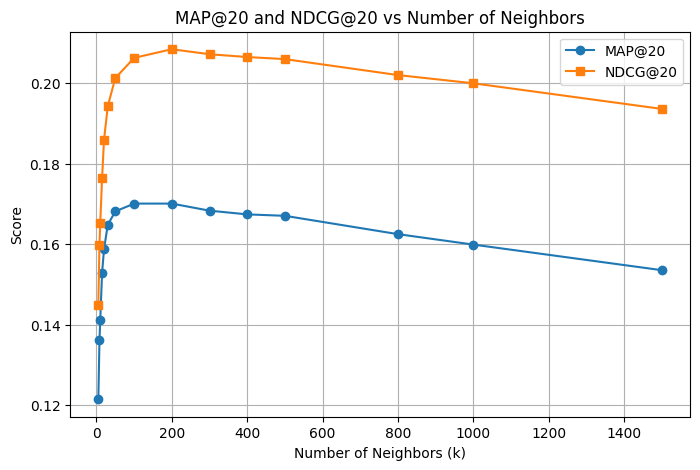

In [78]:
plt.figure(figsize=(8, 5))
plt.plot(num_neighbors, mapk_results, marker='o', label='MAP@20')
plt.plot(num_neighbors, ndcg_results, marker='s', label='NDCG@20')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()

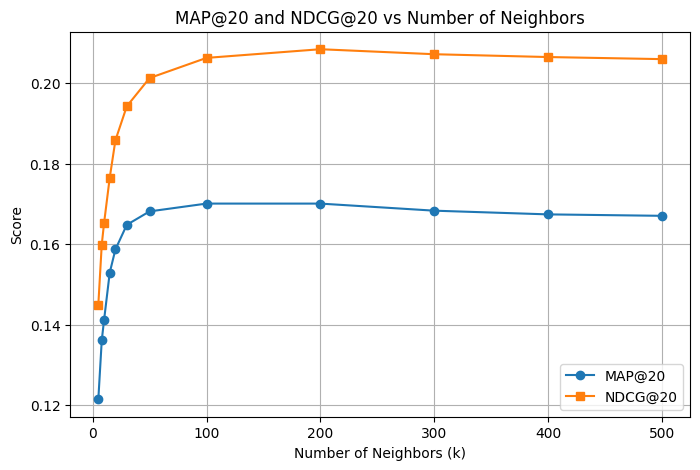

In [86]:
plt.figure(figsize=(8, 5))
plt.plot(num_neighbors[:len(num_neighbors) -3], mapk_results[:len(num_neighbors) -3], marker='o', label='MAP@20')
plt.plot(num_neighbors[:len(num_neighbors) -3], ndcg_results[:len(num_neighbors) -3], marker='s', label='NDCG@20')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
num_neighbors = [10, 50, 100, 125, 150, 200, 225, 250, 275, 300]

In [53]:
rng = np.random.RandomState(RANDOM_STATE)
user_indices = rng.choice(train_matrix_k.shape[0], size=4000, replace=False)

In [54]:
real_items = []
user_based_recommenders = []
predicted_items = []

for k in num_neighbors:
    user_based_recommenders.append(UserBasedRecommender(train_matrix_k, track_uniques, df_music_info, num_neighbors=k))
    predicted_items.append([])

for user_index in tqdm(user_indices):
    real_indexes = val_matrix_k[user_index].nonzero()[1]
    real_items.append(set(track_uniques[real_indexes]))

    for recommender_index, recommender in enumerate(user_based_recommenders):
        recommender.make_recommendations(user_index, n=20)
        predicted_items[recommender_index].append(recommender.get_recommendations_ids())

100%|██████████| 4000/4000 [1:40:45<00:00,  1.51s/it]


In [55]:
mapk_results = []
ndcg_results = []

for recommender_index, recommender in enumerate(user_based_recommenders):
    mapk_result = mapk(real_items, predicted_items[recommender_index], k=20)
    ndcg_result = mean_ndcg(real_items, predicted_items[recommender_index], k=20)
    
    mapk_results.append(mapk_result)
    ndcg_results.append(ndcg_result)

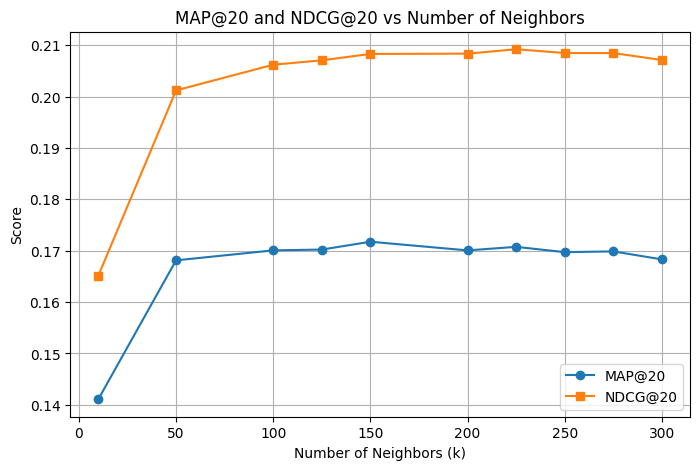

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(num_neighbors, mapk_results, marker='o', label='MAP@20')
plt.plot(num_neighbors, ndcg_results, marker='s', label='NDCG@20')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
mapk_results

[np.float64(0.1410822284838055),
 np.float64(0.16812711743021339),
 np.float64(0.17006562806066483),
 np.float64(0.17022470876646573),
 np.float64(0.1717463962926908),
 np.float64(0.17006217941737486),
 np.float64(0.17075170130007591),
 np.float64(0.16971586249577733),
 np.float64(0.16986575110046473),
 np.float64(0.1683061136006666)]

In [61]:
ndcg_results

[np.float64(0.16513801389466737),
 np.float64(0.20121716802265935),
 np.float64(0.20621732526336353),
 np.float64(0.20707469415842536),
 np.float64(0.20831505673249065),
 np.float64(0.20836904926018834),
 np.float64(0.2092338810880097),
 np.float64(0.208487085238007),
 np.float64(0.20848851405152824),
 np.float64(0.20712735912711513)]

In [29]:
num_neighbors = [100, 110, 120, 130, 140, 150, 160, 180, 190, 200, 210, 220, 240, 250, 260, 270, 280]

In [30]:
rng = np.random.RandomState(RANDOM_STATE)
user_indices = rng.choice(train_matrix_k.shape[0], size=4000, replace=False)

In [31]:
real_items = []
user_based_recommenders = []
predicted_items = []

for k in num_neighbors:
    user_based_recommenders.append(UserBasedRecommender(train_matrix_k, track_uniques, df_music_info, num_neighbors=k))
    predicted_items.append([])

for user_index in tqdm(user_indices):
    real_indexes = val_matrix_k[user_index].nonzero()[1]
    real_items.append(set(track_uniques[real_indexes]))

    for recommender_index, recommender in enumerate(user_based_recommenders):
        recommender.make_recommendations(user_index, n=20)
        predicted_items[recommender_index].append(recommender.get_recommendations_ids())

100%|██████████| 4000/4000 [2:49:51<00:00,  2.55s/it]  


In [ ]:
mapk_results_final = []
ndcg_results_final = []

for recommender_index, recommender in enumerate(user_based_recommenders):
    mapk_result = mapk(real_items, predicted_items[recommender_index], k=20)
    ndcg_result = mean_ndcg(real_items, predicted_items[recommender_index], k=20)
    
    mapk_results_final.append(mapk_result)
    ndcg_results_final.append(ndcg_result)

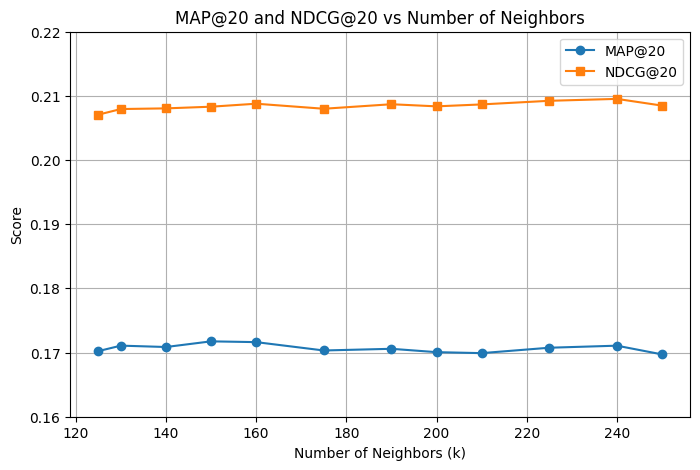

In [68]:
plt.figure(figsize=(8, 5))
plt.plot(num_neighbors, mapk_results_final, marker='o', label='MAP@20')
plt.plot(num_neighbors, ndcg_results_final, marker='s', label='NDCG@20')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Number of Neighbors')
plt.ylim(0.16, 0.22)
plt.legend()
plt.grid(True)
plt.show()

In [70]:
print("Top 5 MAP@20 scores:")
for i in np.argsort(mapk_results_final)[-5:][::-1]:
    print(f"Number of Neighbors: {num_neighbors[i]}, MAP@20: {mapk_results_final[i]:.4f}, NDCG@20: {ndcg_results_final[i]:.4f}")
print("Top 5 NDCG@20 scores:")
for i in np.argsort(ndcg_results_final)[-5:][::-1]:
    print(f"Number of Neighbors: {num_neighbors[i]}, MAP@20: {mapk_results_final[i]:.4f}, NDCG@20: {ndcg_results_final[i]:.4f}")

Top 5 MAP@20 scores:
Number of Neighbors: 150, MAP@20: 0.1717, NDCG@20: 0.2083
Number of Neighbors: 160, MAP@20: 0.1716, NDCG@20: 0.2088
Number of Neighbors: 130, MAP@20: 0.1711, NDCG@20: 0.2080
Number of Neighbors: 240, MAP@20: 0.1711, NDCG@20: 0.2095
Number of Neighbors: 140, MAP@20: 0.1709, NDCG@20: 0.2081
Top 5 NDCG@20 scores:
Number of Neighbors: 240, MAP@20: 0.1711, NDCG@20: 0.2095
Number of Neighbors: 225, MAP@20: 0.1708, NDCG@20: 0.2092
Number of Neighbors: 160, MAP@20: 0.1716, NDCG@20: 0.2088
Number of Neighbors: 190, MAP@20: 0.1706, NDCG@20: 0.2087
Number of Neighbors: 210, MAP@20: 0.1699, NDCG@20: 0.2087


We will chose 160 neighbors because of the high MAP@20 (second best) and NDCG@20 (third best). Nevertheless, all values in between 100 and 300 neighbors have similar values and could be used.